In [2]:
%matplotlib inline
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable


In [3]:
# 查看准确率
net_to_save_dir = "Saved_Models"
saved_model_names = ['Best_model.t7', 'Best_model_fl.t7']
fold=5
enabled_nets = ["ACCNN", "AlexNet", "VGG11", "ResNet18"]
enabled_datasets = ["FER2013", "CK+", "JAFFE"]
for net in enabled_nets:
    for dataset in enabled_datasets:
        for saved_model_name in saved_model_names:
            net_to_save_path = os.path.join(net_to_save_dir, str(fold), dataset + '_' + net + "_" + str(fold))
            if os.path.exists(os.path.join(net_to_save_path, saved_model_name)):
                checkpoint = torch.load(os.path.join(net_to_save_path, saved_model_name))
                best_test_acc = checkpoint['best_test_acc']
                best_test_acc_epoch = checkpoint['best_test_acc_epoch']
                currect_map = checkpoint['correct_map']
                print("---------------net: %s, dataset: %s saved_model_name:%s---------------" % (net, dataset, saved_model_name))
                print("best_test_acc:", best_test_acc)
                print("best_test_acc_epoch:", best_test_acc_epoch)
                if 'best_train_acc' in checkpoint:
                    best_train_acc = checkpoint['best_train_acc']
                    best_train_acc_epoch = checkpoint['best_train_acc_epoch']
                    print("best_train_acc:", best_train_acc)
                    print("best_train_acc_epoch:", best_train_acc_epoch)
                print("currect_map:", currect_map)

---------------net: ACCNN, dataset: FER2013 saved_model_name:Best_model.t7---------------
best_test_acc: 68.76606683804627
best_test_acc_epoch: 2276
currect_map: [192, 0, 140, 603, 123, 213, 334]
---------------net: ACCNN, dataset: FER2013 saved_model_name:Best_model_fl.t7---------------
best_test_acc: 64.14206247325632
best_test_acc_epoch: 966
currect_map: [175, 0, 109, 587, 130, 197, 301]
---------------net: ACCNN, dataset: CK+ saved_model_name:Best_model.t7---------------
best_test_acc: 100.0
best_test_acc_epoch: 2912
currect_map: [6, 9, 18, 3, 12, 6, 21]
---------------net: ACCNN, dataset: CK+ saved_model_name:Best_model_fl.t7---------------
best_test_acc: 100.0
best_test_acc_epoch: 2009
best_train_acc: 99.44812362030905
best_train_acc_epoch: 2009
currect_map: [6, 9, 18, 3, 12, 6, 21]
---------------net: ACCNN, dataset: JAFFE saved_model_name:Best_model.t7---------------
best_test_acc: 95.23809523809523
best_test_acc_epoch: 163
best_train_acc: 92.70833333333334
best_train_acc_epoch

In [4]:
# 对比脸定位部剪裁前后的训练结果
net_to_save_dir = "Saved_Models"
saved_model_name = 'Best_model.t7'
fold=[2, 3]
# enabled_nets = ["ACNN", "ACCNN", "AlexNet"]
enabled_nets = ["ACCNN"]
enabled_datasets = ["JAFFE"]
for f in fold:
    for net in enabled_nets:
        for dataset in enabled_datasets:
            net_to_save_path = os.path.join(net_to_save_dir, dataset + '_' + net + "_" + str(f))
            checkpoint = torch.load(os.path.join(net_to_save_path, saved_model_name))
            best_acc = checkpoint['best_test_acc']
            best_acc_epoch = checkpoint['best_test_acc_epoch']
            currect_map = checkpoint['correct_map']
            print("---------------net: %s, dataset: %s---------------" % (net, dataset))
            print("best_acc:", best_acc)
            print("best_acc_epoch:", best_acc_epoch)
            print("currect_map:", currect_map)

---------------net: ACCNN, dataset: JAFFE---------------
best_acc: 57
best_acc_epoch: 232
currect_map: [3, 2, 0, 3, 3, 0, 1]
---------------net: ACCNN, dataset: JAFFE---------------
best_acc: 14
best_acc_epoch: 0
currect_map: [0, 0, 0, 0, 3, 0, 0]


In [ ]:
from networks.ACNN import ACNN
from networks.ACCNN import ACCNN
from networks.AlexNet import AlexNet
from dal.CKPlus48_DataSet import CKPlus48
from dal.FER2013_DataSet import FER2013
from dal.JAFFE_DataSet import JAFFE
import transforms.transforms as transforms
from utils.utils import draw_img
from PIL import Image
from math import ceil, floor
import torch.nn as nn

In [ ]:
# 配置信息
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
net_name, n_classes = 'ACCNN', 7

if net_name == "ACNN":
    net = ACNN(n_classes=n_classes).to(DEVICE)
elif net_name == "ACCNN":
    net = ACCNN(n_classes=n_classes).to(DEVICE)
elif net_name == "AlexNet":
    net = AlexNet(n_classes=n_classes).to(DEVICE)
input_img_size = net.input_size
transform_train = transforms.Compose([
    transforms.Resize(input_img_size),  # 缩放将图片的最小边缩放为 input_img_size，因此如果输入是费正方形的，那么输出也不是正方形的
    transforms.RandomCrop(input_img_size),  # 用于将非正方形的图片进行处理
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_img_size = int(input_img_size * 1.1)  # 测试时，图片resize大小
transform_test = transforms.Compose([
    transforms.Resize(test_img_size),
    transforms.TenCrop(input_img_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])
dataset = 'CK+'
target_type='ls'
if dataset == "JAFFE":
    test_data = JAFFE(is_train=False, transform=transform_test, target_type=target_type)
elif dataset == "CK+48":
    test_data = CKPlus48(is_train=False, transform=transform_test, target_type=target_type)
elif dataset == "CK+":
    test_data = CKPlus48(is_train=False, transform=transform_test, target_type=target_type, img_dir_pre_path="data/CK+")
elif dataset == "FER2013":
    test_data = FER2013(is_train=False, private_test=True, transform=transform_test, target_type=target_type)
else:
    assert("opt.dataset should be in %s, but got %s" % (enabled_datasets, dataset))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# 获取model
net_to_save_path = os.path.join(net_to_save_dir, dataset + '_' + net_name + "_" + str(fold))
print("get net parameters from:", net_to_save_path)
checkpoint = torch.load(os.path.join(net_to_save_path, saved_model_name))
net.load_state_dict(checkpoint['net'])
print("---------------net: %s, dataset: %s---------------" % (net_name, dataset))

In [ ]:
# 获取数据
inputs, targets = next(iter(test_loader))
# print(inputs.shape, targets)
# input = inputs[0][0][0]
# print(input.shape)
# draw_img(input)

bs, ncrops, c, h, w = np.shape(inputs)
inputs = inputs.view(-1, c, h, w)
if use_cuda:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
inputs, targets = Variable(inputs), Variable(targets)

In [ ]:
def draw_features_of_layer(layer_number=-1, blank_size = 2, img_save_dir = "Saved_Virtualizations", img_save_name = "default"):
    '''
    绘制特征层的输出情况，layer_number=-1表示绘制最后一层
    '''
    # 绑定并测试
    features_hook = []
    def get_features_hook(self,input,output):
        features_hook.append(input)

    if layer_number >= 0:
        handler = net.features[layer_number].register_forward_hook(get_features_hook)
    else:
        handler = net.features[-1].register_forward_hook(get_features_hook)
    with torch.no_grad():
        outputs = net(inputs)
    handler.remove()

    # 可视化展示
    images = np.array(features_hook[0][0].cpu())
#     print(images.shape)
    for i in range(len(images)):
        print("-----------img %s layer %s------------" % (str(i), str(layer_number)))
        image = images[i]
#         print("image shape:", image.shape)
        image_shape = image.shape
        col_num = int(ceil(image_shape[0] ** 0.5))
        row_num = int(ceil(image_shape[0] / col_num))
        height =  row_num * image_shape[1]
        width =  col_num * image_shape[2]
#         print(col_num, row_num, height, width)
        img_arr = np.array([[0.5 for _ in range(width+(col_num-1)*blank_size)]for _ in range(height+(row_num-1)*blank_size)])
        for j in range(len(image)):
            start_row_index, start_col_index =  (j//col_num)*(blank_size+image_shape[1]), (j%col_num)*(blank_size+image_shape[2])
            for row_pixel_index in range(image_shape[1]):
                for col_pixel_index in range(image_shape[2]):
                    img_arr[start_row_index+row_pixel_index][start_col_index+col_pixel_index] = image[j][row_pixel_index][col_pixel_index]
        img = Image.fromarray(img_arr)
        if not os.path.exists(img_save_dir):
            os.mkdir(img_save_dir)
        draw_img(img, os.path.join(img_save_dir, img_save_name+"_of_img_"+str(i)))
        break

In [ ]:
print(net.features)
feature_indexes = [0,3,6,9,-1]
for i in range(len(feature_indexes)):
    idx = feature_indexes[i] 
#     draw_features_of_layer(i, img_save_name="feature_layer_"+str(i))
#     print(net.features[idx])

In [ ]:
for layer in net.named_modules():
    if isinstance(layer[1],nn.Conv2d):
         print(layer)

In [ ]:
def draw_features_of_net(net, img_name_pre = "", blank_size = 2, img_save_dir = "Saved_Virtualizations"):
    '''
    绘制网络所有的特征层的输出情况
    '''
    # 绑定并测试
    features_hook = []
    def get_features_hook(self,input,output):
        features_hook.append(input)
    handlers = []
    for layer in net.named_modules():
        if isinstance(layer[1],nn.Conv2d):
            handlers.append(layer[1].register_forward_hook(get_features_hook))
    with torch.no_grad():
        outputs = net(inputs)
        features_hook.append(net.features_out)
    for handler in handlers:
        handler.remove()

    # 可视化展示
    for layer_number in range(len(features_hook)):
        images = np.array(features_hook[layer_number][0].cpu())
#         print(images.shape)
        img_save_name = img_name_pre + "_feature_layer_" + str(layer_number)
        for i in range(len(images)):
#             print("-----------img %s------------" % str(i))
            image = images[i]
#             print("image shape:", image.shape)
            image_shape = image.shape
            col_num = int(ceil(image_shape[0] ** 0.5))
            row_num = int(ceil(image_shape[0] / col_num))
            height =  row_num * image_shape[1]
            width =  col_num * image_shape[2]
#             print(col_num, row_num, height, width)
            img_arr = np.array([[0.5 for _ in range(width+(col_num-1)*blank_size)]for _ in range(height+(row_num-1)*blank_size)])
            for j in range(len(image)):
                start_row_index, start_col_index =  (j//col_num)*(blank_size+image_shape[1]), (j%col_num)*(blank_size+image_shape[2])
                for row_pixel_index in range(image_shape[1]):
                    for col_pixel_index in range(image_shape[2]):
                        img_arr[start_row_index+row_pixel_index][start_col_index+col_pixel_index] = image[j][row_pixel_index][col_pixel_index]
            img = Image.fromarray(img_arr)
            if not os.path.exists(img_save_dir):
                os.mkdir(img_save_dir)
            draw_img(img, os.path.join(img_save_dir, img_save_name+"_of_img_"+str(i)))
            break

In [ ]:
draw_features_of_net(net, 'test')

In [ ]:
def draw_weights_of_net(net, img_name_pre = "", blank_size = 2, img_save_dir = "Saved_Virtualizations"):
    layer_number = 0
    stat_dict = net.state_dict()
    for dic in stat_dict.keys():
        dic_splited = dic.split(".")
        if dic_splited[0] == 'features' and dic_splited[2] == 'weight':
            img_save_name = img_name_pre + "_weight_layer_" + str(layer_number)
            weights = stat_dict[dic]
#             print(dic, weights)
            out_channel_num = len(weights)
            in_channel_num = len(weights[0])
            kernel_height = len(weights[0][0])
            kernel_width = len(weights[0][0][0])
            img_arr = np.array([[0.5 for _ in range(kernel_width*in_channel_num+(in_channel_num-1)*blank_size)]for _ in range(kernel_height*out_channel_num+(out_channel_num-1)*blank_size)])
#             print(img_arr.shape)
            for out_channel_number in range(out_channel_num):
                for in_channel_number in range(in_channel_num):
                    start_row_index, start_col_index = (out_channel_number)*(blank_size+kernel_height), (in_channel_number)*(blank_size+kernel_width)
                    kernel = weights[out_channel_number][in_channel_number]
#                     print(kernel.shape)
                    for row_pixel_index in range(kernel.shape[0]):
                        for col_pixel_index in range(kernel.shape[1]):
                            img_arr[start_row_index+row_pixel_index][start_col_index+col_pixel_index] = kernel[row_pixel_index][col_pixel_index]
            img = Image.fromarray(img_arr)
            if not os.path.exists(img_save_dir):
                os.mkdir(img_save_dir)
            draw_img(img, os.path.join(img_save_dir, img_save_name))
            layer_number += 1
draw_weights_of_net(net.cpu(), 'test')

以下部分用于测试训练完毕后的使用代码
------

In [1]:
import sys
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
sys.path.append("..")
from networks.ACCNN import ACCNN
import transforms.transforms as transforms

In [2]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")
model = ACCNN(7, True).to(DEVICE)

Loading parameters...
Loading parameters over!


In [5]:
# img_path = 'data/CK+/sadness/S011_002_00000020.png'
img_path = 'data/CK+/sadness/S501_006_00000039.png'
img = Image.open(img_path)
img = img.convert("L")
transform_test = transforms.Compose([
    transforms.Resize(int(model.input_size*1.1)),
    transforms.TenCrop(model.input_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])
inputs = transform_test(img)
bs = 1
ncrops, c, h, w = np.shape(inputs)
with torch.no_grad():
    inputs = inputs.view(-1, c, h, w)
    if use_cuda:
        inputs = inputs.to(DEVICE)
    inputs = Variable(inputs)
    outputs = model(inputs)
    outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
    print(outputs, outputs_avg)
    _, predicted = torch.max(outputs_avg.data, 1)
    print(model.output_map[predicted.item()])

tensor([[0.1397, 0.0186, 0.1559, 0.0383, 0.4064, 0.0089, 0.2322],
        [0.1403, 0.0134, 0.1791, 0.1949, 0.3195, 0.0480, 0.1046],
        [0.1059, 0.0160, 0.3123, 0.1040, 0.2470, 0.1073, 0.1075],
        [0.1074, 0.0110, 0.1622, 0.1667, 0.2656, 0.0605, 0.2265],
        [0.0262, 0.0044, 0.0348, 0.0122, 0.2909, 0.0029, 0.6285],
        [0.0610, 0.0081, 0.0860, 0.1612, 0.2853, 0.0106, 0.3878],
        [0.0480, 0.0034, 0.1019, 0.3117, 0.1733, 0.0961, 0.2657],
        [0.1149, 0.0129, 0.1465, 0.0596, 0.2909, 0.0242, 0.3511],
        [0.0791, 0.0154, 0.3402, 0.0299, 0.3361, 0.0864, 0.1129],
        [0.0495, 0.0042, 0.0517, 0.0325, 0.1549, 0.0130, 0.6942]],
       device='cuda:0') tensor([[0.0872, 0.0108, 0.1571, 0.1111, 0.2770, 0.0458, 0.3111]],
       device='cuda:0')
中性


以下代码用于绘制history数据的可视化
--

In [6]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
pre_path = 'E:/毕设\代码/my_scripts/Saved_Models/5'
save_path = 'E:/毕设/代码/my_scripts/Saved_Virtualizations'

In [7]:
def read_hisroty_file(file_path):
    print("--------------reading:%s-----------" % file_path)
    with open(file_path, "r") as file:
        lines = file.readlines()
    train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss = [], [], [], [], [], []
    index = 0
    print(len(lines))
    for line in lines:
        epoch = int(index/2)
        index += 1
        line_splited = line.split(" ")[:-1]
        if line_splited[0] == "Train":
            if len(line_splited) == 4:
                epoch = int(line_splited[1])
                train_acc_data = float(line_splited[2])
                train_loss_data = float(line_splited[3])
            elif len(line_splited) == 3:
                train_acc_data = float(line_splited[1])
                train_loss_data = float(line_splited[2])
            else:
                print("Error line_splited")
                continue
            train_epoch.append(epoch)
            train_acc.append(train_acc_data)
            train_loss.append(train_loss_data)
        else:
            line_splited = line.split(" [")[0].split(" ")
            if len(line_splited) == 4:
                epoch = int(line_splited[1])
                test_acc_data = float(line_splited[2])
                test_loss_data = float(line_splited[3])
            elif len(line_splited) == 3:
                test_acc_data = float(line_splited[1])
                test_loss_data = float(line_splited[2])
            else:
                print("Error line_splited")
                continue
            test_epoch.append(epoch)
            test_acc.append(test_acc_data)
            test_loss.append(test_loss_data)
    print(len(train_epoch), len(train_acc), len(train_loss))
    print(len(test_epoch), len(test_acc), len(test_loss))
    return train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss

def draw_history(history_file_name, data):
    fig = plt.figure(figsize=(20, 20))
    diff_his_color = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    
    ax = fig.add_subplot(221)
    for index in range(len(data)):
        train_epoch, train_acc, _, _, _, _, name = data[index]
        ax.plot(train_epoch, train_acc, diff_his_color[index]+'-', label='train_acc_'+name)
    ax.set_title('history_file: %s' % history_file_name)
    ax.set_xlabel('epoch')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid()
    
    ax = fig.add_subplot(222)
    for index in range(len(data)):
        _, _, _, test_epoch, test_acc, _, name = data[index]
        ax.plot(test_epoch, test_acc, diff_his_color[index]+'-', label='test_acc_'+name)
    ax.set_title('history_file: %s' % history_file_name)
    ax.set_xlabel('epoch')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid()
    
    ax = fig.add_subplot(223)
    for index in range(len(data)):
        train_epoch, _, train_loss, _, _, _, name = data[index]
        ax.plot(train_epoch, train_loss, diff_his_color[index]+'-',label='train_loss_'+name)
    ax.set_title('history_file: %s' % history_file_name)
    ax.set_xlabel('epoch')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid()
    
    ax = fig.add_subplot(224)
    for index in range(len(data)):
        _, _, _, test_epoch, _, test_loss, name = data[index]
        ax.plot(test_epoch, test_loss, diff_his_color[index]+'-', label='test_loss_'+name)
    ax.set_title('history_file: %s' % history_file_name)
    ax.set_xlabel('epoch')
    ax.set_ylabel('value')
    ax.legend()
    ax.grid()
    
    plt.savefig(os.path.join(save_path, history_file_name+".png"))
    plt.show()
    

--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history_fl_0_372.txt-----------
762
381 381 381
381 381 381
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history_fl_1_373.txt-----------
749
375 375 375
374 374 374
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history_fl_2_121.txt-----------
244
122 122 122
122 122 122
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history_fl_3_125.txt-----------
252
126 126 126
126 126 126
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history_fl.txt-----------
2302
1151 1151 1151
1151 1151 1151


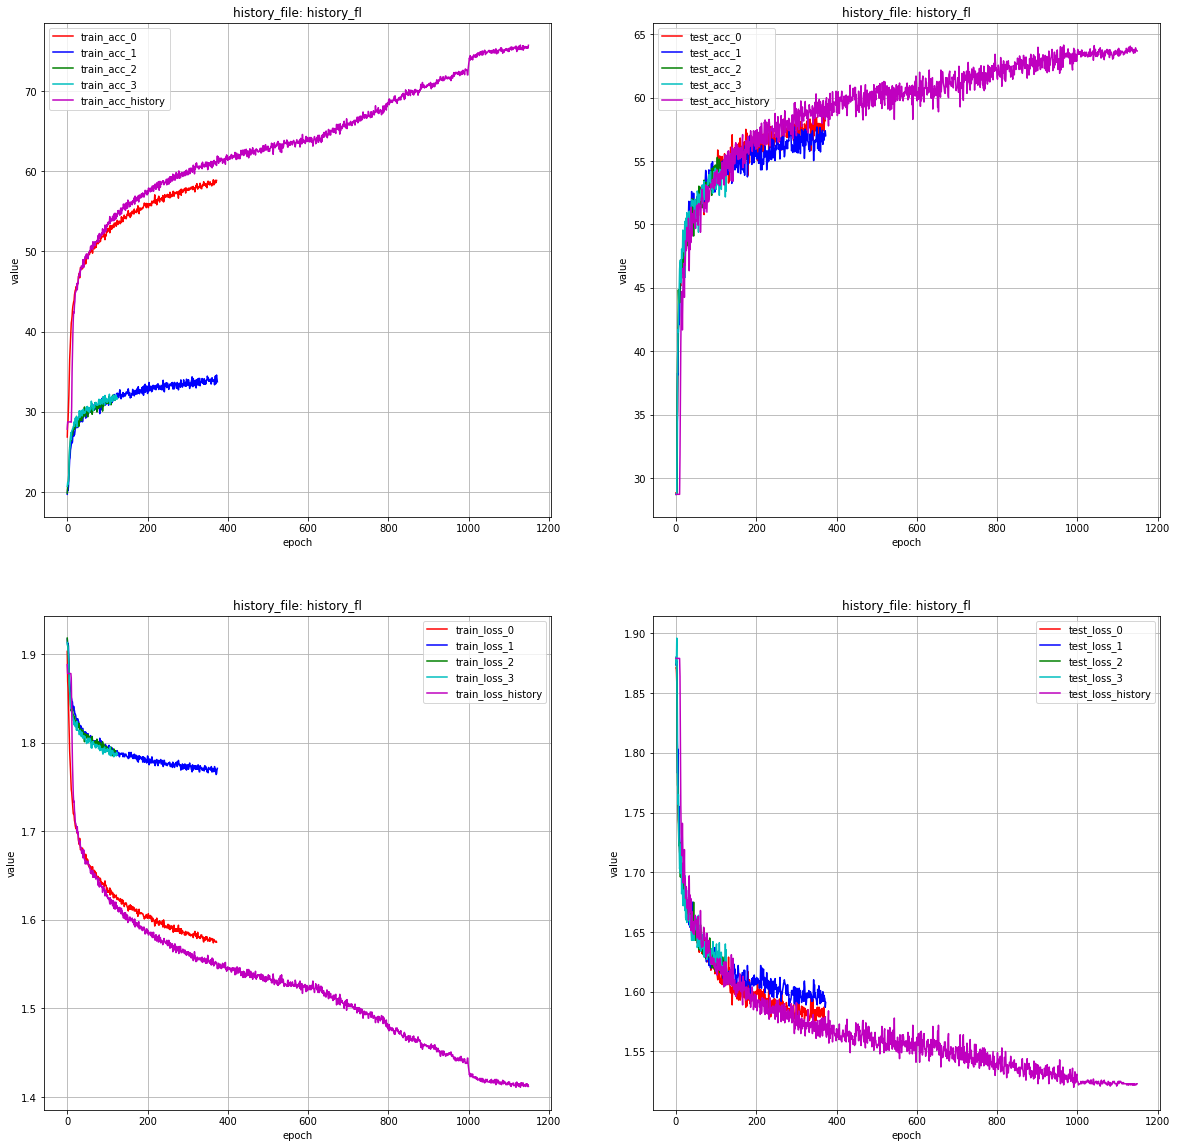

In [8]:
# 绘制ACCNN的几种结构的训练情况
models_dir = ['FER2013_ACCNN_5']
history_file_names = ["history_fl_0_372.txt", "history_fl_1_373.txt", "history_fl_2_121.txt", "history_fl_3_125.txt", "history_fl.txt"]
saved_name = "history_fl"
# history_file_names = ["history_0_271.txt", "history_1_164.txt", "history_2_185.txt", "history_3_266.txt", "history.txt"]
# saved_name = "history"
for model in models_dir:
    data = []
    for history_file_name in history_file_names:
        file_path = os.path.join(pre_path, model, history_file_name)
        if os.path.exists(file_path):
            train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss = read_hisroty_file(file_path)
            temp = history_file_name.split("_")
            if len(temp) <= 2:
                name = temp[0]
            else:
                name = temp[-2]
            data.append([train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss, name])
    draw_history(saved_name, data)

--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ACCNN_5\history.txt-----------
4089
2045 2045 2045
2044 2044 2044
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_AlexNet_5\history.txt-----------
2134
1067 1067 1067
1067 1067 1067
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_ResNet18_5\history.txt-----------
400
200 200 200
200 200 200
--------------reading:E:/毕设\代码/my_scripts/Saved_Models/5\FER2013_VGG11_5\history.txt-----------
420
210 210 210
210 210 210


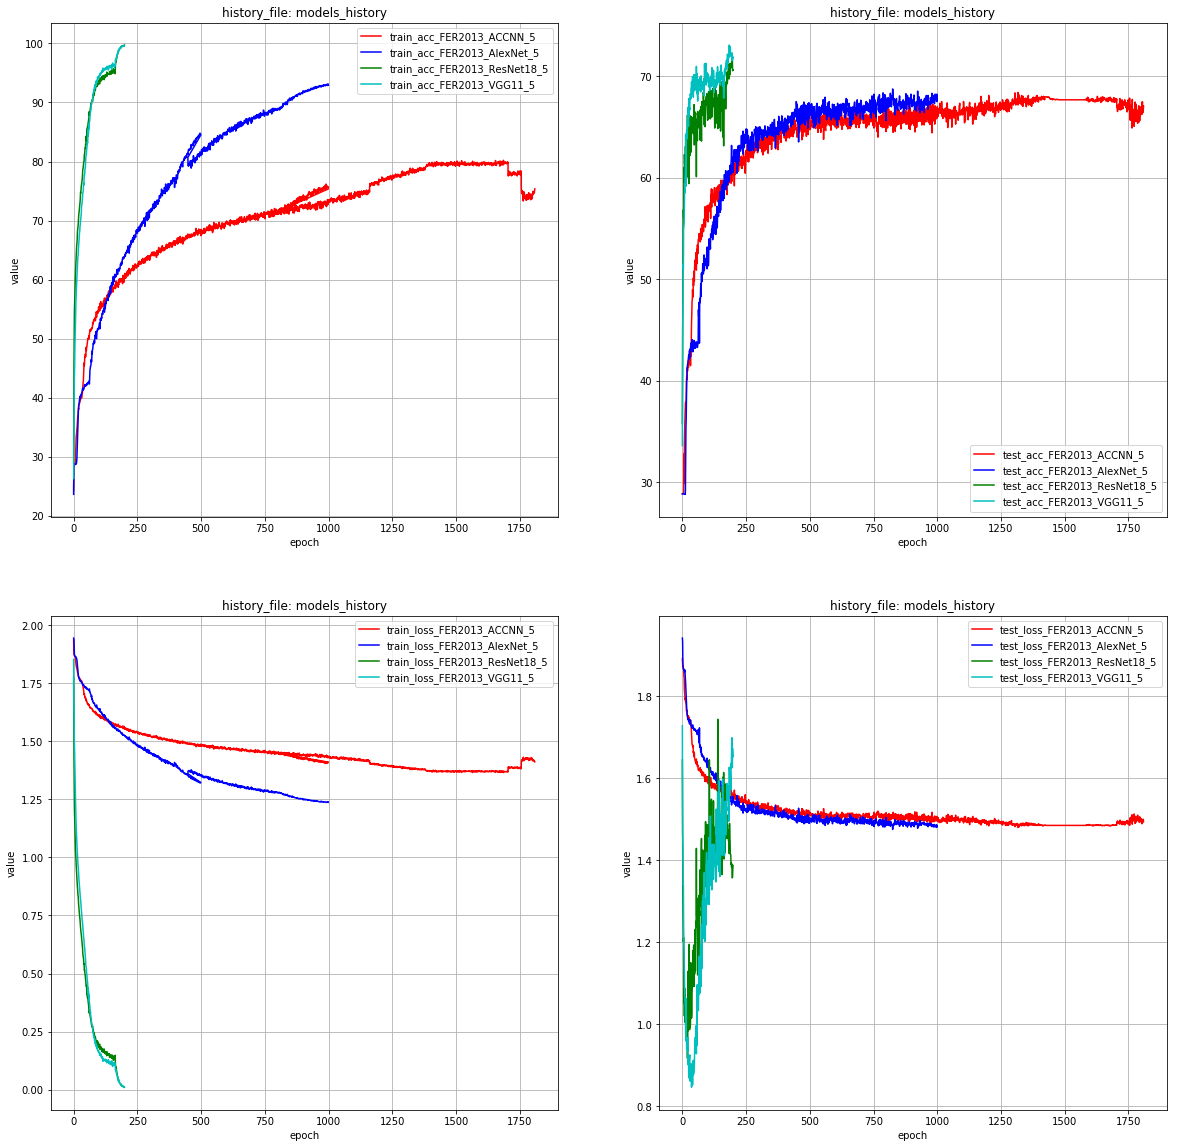

In [9]:
# 绘制不同模型的训练情况
models_dir = os.listdir(pre_path)
history_file_name = "history.txt"
saved_name = "models_history"
data = []
for model in models_dir:
    file_path = os.path.join(pre_path, model, history_file_name)
    if os.path.exists(file_path):
        train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss = read_hisroty_file(file_path)
        data.append([train_epoch, train_acc, train_loss, test_epoch, test_acc, test_loss, model])
draw_history(saved_name, data)